# InfoGAN MNIST

This notebook is for implementing `InfoGAN` from the paper [InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets](https://arxiv.org/abs/1606.03657) with [Tensorflow](https://www.tensorflow.org). <br>
[MNIST data](http://yann.lecun.com/exdb/mnist/) will be used.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

## Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

## Parameters


In [3]:
img_size   = 28

batch_size = 128
num_epoch  = 50

n_latent = 100
n_code = 12 
n_discrete = 10
n_continuous = 2

beta1 = 0.5

learning_rate_g = 0.0002
learning_rate_d = 0.0002

show_result_epoch = 5

gpu_fraction = 0.3 

## Import MNIST Dataset

Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [5]:
x_train = mnist[0][0]
y_train = mnist[0][1]
x_test  = mnist[1][0]
y_test  = mnist[1][1]

print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('x_test shape: {}'.format(x_test.shape))
print('y_test shape: {}'.format(y_test.shape))

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


## Generator

In [6]:
def Generator(x, c, is_training, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):       
        x_concat = tf.concat([x, c], -1)
        
        # Project and Reshape 
        w1 = tf.get_variable('w1', [x_concat.get_shape()[1], 7*7*512])
        b1 = tf.get_variable('b1', [7*7*512])
        
        x_project = tf.matmul(x_concat,w1)+b1
        x_reshape = tf.reshape(x_project, (-1, 7, 7, 512))
        
        # First deconv layer
        h1 = tf.layers.conv2d_transpose(x_reshape,filters=256, kernel_size=5, strides=1, padding='SAME')
        h1 = tf.nn.leaky_relu(h1)
        
        # Second deconv layer
        h2 = tf.layers.conv2d_transpose(h1,filters=128, kernel_size=5, strides=2, padding='SAME')
        h2 = tf.layers.batch_normalization(h2, training=is_training)
        h2 = tf.nn.leaky_relu(h2)  
        
        # Third deconv layer 
        h3 = tf.layers.conv2d_transpose(h2, filters=64, kernel_size=5, strides=2, padding='SAME')
        h3 = tf.layers.batch_normalization(h3, training=is_training)
        h3 = tf.nn.leaky_relu(h3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(h3, filters=1, kernel_size=5, strides=1, padding='SAME')     
        output = tf.tanh(logits)
                
        return output

## Discriminator

In [7]:
def Discriminator(x, is_training, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        # First conv layer
        h1 = tf.layers.conv2d(x, filters=32, kernel_size=5, strides=2, padding='SAME')
        h1 = tf.nn.leaky_relu(h1)
        
        # Second conv layer
        h2 = tf.layers.conv2d(h1, filters=64, kernel_size=5, strides=2, padding='SAME')
        h2 = tf.layers.batch_normalization(h2, training=is_training)
        h2 = tf.nn.leaky_relu(h2)
        
        # Trhid conv layer
        h3 = tf.layers.conv2d(h2, filters=128, kernel_size=5, strides=2, padding='SAME')
        h3 = tf.layers.batch_normalization(h3, training=is_training)
        h3 = tf.nn.leaky_relu(h3)
        
        # Output layer
        flatten = tf.reshape(h3, (-1, h3.get_shape()[1]*h3.get_shape()[2]*h3.get_shape()[3]))
        
        logit  = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logit)  
        
        c1  = tf.layers.dense(flatten, 256)
        c2  = tf.layers.dense(c1, 256)
        c_logit = tf.layers.dense(c2, n_code)
        c_output = tf.concat([tf.nn.softmax(c_logit[:,:n_discrete]), c_logit[:, n_discrete:]], 1)  

        return logit, output, c_output

## GAN

In [8]:
def GAN(x, c, z, is_training):
    # Generator  
    G = Generator(z, c, is_training)
    
    # Discriminator
    D_logit_real, D_out_real,_ = Discriminator(x, is_training)
    D_logit_fake, D_out_fake, c_output = Discriminator(G, is_training, reuse=True)
    
    # get loss (LSGAN Loss)
    d_loss = tf.reduce_mean(tf.square(D_logit_real-1)) + tf.reduce_mean(tf.square(D_logit_fake))
    g_loss = tf.reduce_mean(tf.square(D_logit_fake-1))

    # get Q loss
    q_loss_discrete = tf.reduce_mean(tf.reduce_sum(tf.square(c_output[:,:n_discrete] - c[:,:n_discrete])))
    q_loss_continuous = tf.reduce_mean(tf.reduce_sum(tf.square(c_output[:,n_discrete:] - c[:,n_discrete:])))
    
    q_loss = q_loss_discrete + q_loss_continuous

    return d_loss, g_loss, q_loss, G

## Build Graph

In [9]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 1])
x_normalize = (tf.cast(x, tf.float32) - (255.0/2)) / (255.0/2)

z = tf.placeholder(tf.float32, shape=[None, n_latent])

c = tf.placeholder(tf.float32, shape=[None, n_code])

is_training = tf.placeholder(tf.bool)

d_loss, g_loss, q_loss, G = GAN(x_normalize, c, z, is_training) 

# optimization
trainable_variables = tf.trainable_variables()

trainable_variables_d = [var for var in trainable_variables if var.name.startswith('Discriminator')]
trainable_variables_g = [var for var in trainable_variables if var.name.startswith('Generator')]

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step_d = tf.train.AdamOptimizer(learning_rate_d).minimize(d_loss, var_list=trainable_variables_d)
    train_step_g = tf.train.AdamOptimizer(learning_rate_g).minimize(g_loss, var_list=trainable_variables_g)
    train_step_q = tf.train.AdamOptimizer(learning_rate_g).minimize(q_loss)

## Initialization

In [10]:
# Initialize variables
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

## Train

Epoch: 1 / G Loss: 1.06853 / D Loss: 0.03313 / Q Loss: 106.67857


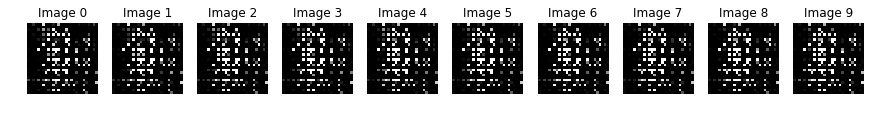

Epoch: 2 / G Loss: 1.08451 / D Loss: 0.11473 / Q Loss: 60.82111
Epoch: 3 / G Loss: 0.80937 / D Loss: 0.18495 / Q Loss: 18.08799
Epoch: 4 / G Loss: 0.78149 / D Loss: 0.20120 / Q Loss: 7.79490
Epoch: 5 / G Loss: 0.91198 / D Loss: 0.23003 / Q Loss: 8.17636


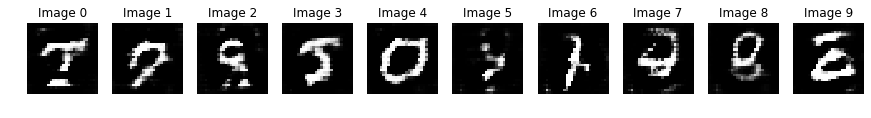

Epoch: 6 / G Loss: 0.73872 / D Loss: 0.31948 / Q Loss: 8.11922
Epoch: 7 / G Loss: 0.61700 / D Loss: 0.35852 / Q Loss: 7.39710
Epoch: 8 / G Loss: 0.62025 / D Loss: 0.25924 / Q Loss: 11.19693
Epoch: 9 / G Loss: 0.68023 / D Loss: 0.27423 / Q Loss: 8.58580
Epoch: 10 / G Loss: 0.68101 / D Loss: 0.23703 / Q Loss: 6.30307


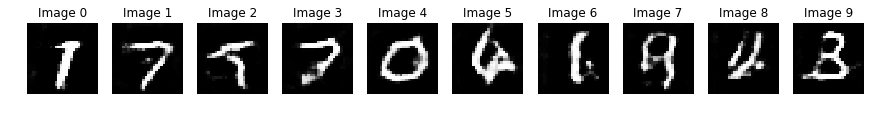

Epoch: 11 / G Loss: 0.62307 / D Loss: 0.24015 / Q Loss: 6.03777
Epoch: 12 / G Loss: 0.69449 / D Loss: 0.23611 / Q Loss: 5.34740
Epoch: 13 / G Loss: 0.64067 / D Loss: 0.42632 / Q Loss: 4.90814
Epoch: 14 / G Loss: 0.89340 / D Loss: 0.24639 / Q Loss: 5.44096
Epoch: 15 / G Loss: 0.94367 / D Loss: 0.17598 / Q Loss: 8.85337


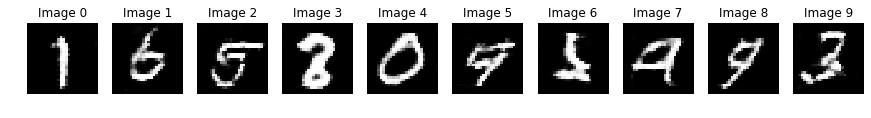

Epoch: 16 / G Loss: 0.80802 / D Loss: 0.29240 / Q Loss: 4.06985
Epoch: 17 / G Loss: 0.64957 / D Loss: 0.25642 / Q Loss: 3.38526
Epoch: 18 / G Loss: 0.73682 / D Loss: 0.27075 / Q Loss: 4.00621
Epoch: 19 / G Loss: 0.67900 / D Loss: 0.21879 / Q Loss: 2.13699
Epoch: 20 / G Loss: 0.27453 / D Loss: 0.51688 / Q Loss: 2.57196


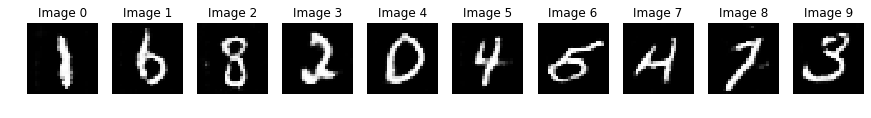

Epoch: 21 / G Loss: 0.56647 / D Loss: 0.33300 / Q Loss: 2.06306
Epoch: 22 / G Loss: 0.59666 / D Loss: 0.43310 / Q Loss: 2.64579
Epoch: 23 / G Loss: 0.26927 / D Loss: 0.53309 / Q Loss: 3.11499
Epoch: 24 / G Loss: 0.49858 / D Loss: 0.44043 / Q Loss: 5.32736
Epoch: 25 / G Loss: 0.45020 / D Loss: 0.43589 / Q Loss: 2.30754


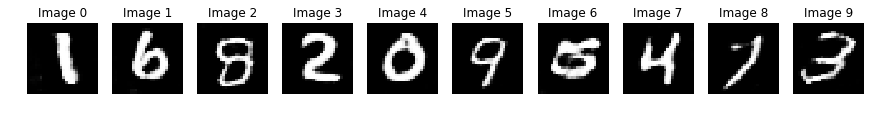

Epoch: 26 / G Loss: 0.44938 / D Loss: 0.39040 / Q Loss: 4.27913
Epoch: 27 / G Loss: 0.57044 / D Loss: 0.30217 / Q Loss: 1.99957
Epoch: 28 / G Loss: 0.61571 / D Loss: 0.41252 / Q Loss: 1.78872
Epoch: 29 / G Loss: 0.40499 / D Loss: 0.30503 / Q Loss: 3.34725
Epoch: 30 / G Loss: 0.52477 / D Loss: 0.40235 / Q Loss: 2.42941


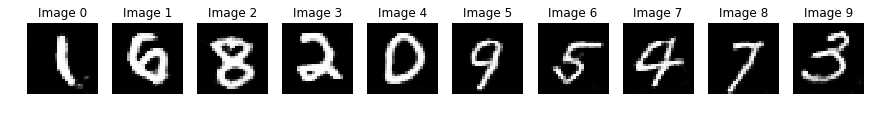

Epoch: 31 / G Loss: 0.67205 / D Loss: 0.32980 / Q Loss: 1.62868
Epoch: 32 / G Loss: 0.35457 / D Loss: 0.49299 / Q Loss: 1.14769
Epoch: 33 / G Loss: 0.38607 / D Loss: 0.39251 / Q Loss: 2.34680
Epoch: 34 / G Loss: 0.35431 / D Loss: 0.53599 / Q Loss: 2.33295
Epoch: 35 / G Loss: 0.30943 / D Loss: 0.39525 / Q Loss: 1.72918


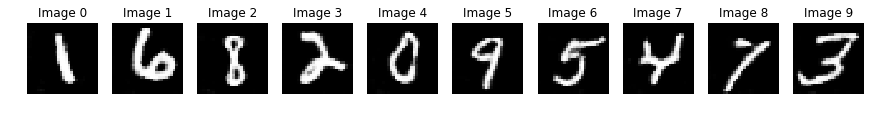

Epoch: 36 / G Loss: 0.45729 / D Loss: 0.39366 / Q Loss: 1.65333
Epoch: 37 / G Loss: 0.43781 / D Loss: 0.46226 / Q Loss: 1.07294
Epoch: 38 / G Loss: 0.33119 / D Loss: 0.46921 / Q Loss: 1.58919
Epoch: 39 / G Loss: 0.41264 / D Loss: 0.49451 / Q Loss: 1.75693
Epoch: 40 / G Loss: 0.27055 / D Loss: 0.51474 / Q Loss: 2.45372


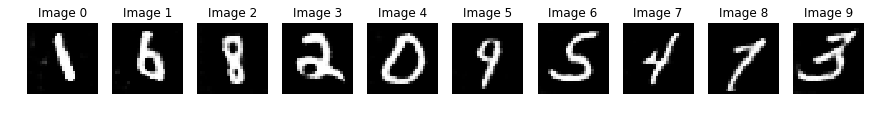

Epoch: 41 / G Loss: 0.36244 / D Loss: 0.43568 / Q Loss: 1.85862
Epoch: 42 / G Loss: 0.39504 / D Loss: 0.43575 / Q Loss: 1.70585
Epoch: 43 / G Loss: 0.56001 / D Loss: 0.23041 / Q Loss: 1.24049
Epoch: 44 / G Loss: 0.46713 / D Loss: 0.44400 / Q Loss: 2.04666
Epoch: 45 / G Loss: 0.33998 / D Loss: 0.39748 / Q Loss: 1.20963


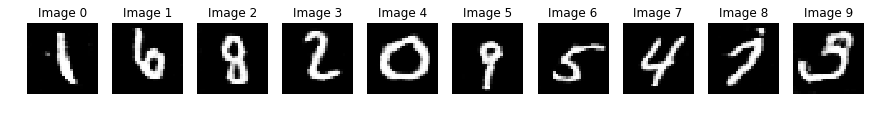

Epoch: 46 / G Loss: 0.48289 / D Loss: 0.36743 / Q Loss: 1.39225
Epoch: 47 / G Loss: 0.49298 / D Loss: 0.36596 / Q Loss: 1.45084
Epoch: 48 / G Loss: 0.37873 / D Loss: 0.37885 / Q Loss: 1.72379
Epoch: 49 / G Loss: 0.41263 / D Loss: 0.39501 / Q Loss: 0.87085
Epoch: 50 / G Loss: 0.29222 / D Loss: 0.44117 / Q Loss: 1.24962


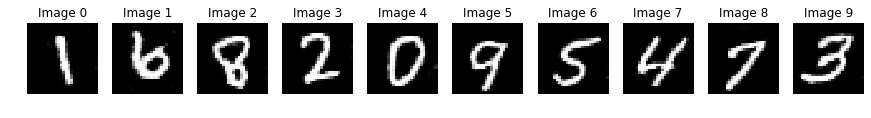

In [11]:
# Training
data_x = x_train
len_data = x_train.shape[0]

for i in range(num_epoch):
    # Shuffle the data 
    np.random.shuffle(data_x)
      
    # Making mini-batch
    for j in range(0, len_data, batch_size):
        if j + batch_size < len_data:
            data_x_in = data_x[j : j + batch_size, :]
        else:
            data_x_in = data_x[j : len_data, :]
        
        data_x_in = data_x_in.reshape((-1, img_size, img_size, 1))
        
        # Get sample z
        sampled_z = np.random.uniform(-1, 1, size=(data_x_in.shape[0] , n_latent))
        
        # Get code 
        c_discrete = np.random.multinomial(1, n_discrete*[1./n_discrete],size=data_x_in.shape[0])
        c_continuous = np.random.uniform(-1, 1, size=(data_x_in.shape[0], n_continuous))
        
        c_batch = np.concatenate((c_discrete, c_continuous), 1)
            
        # Run Optimizer!
        _, loss_d = sess.run([train_step_d, d_loss], feed_dict = {x: data_x_in, c: c_batch, z: sampled_z, is_training: True})
        _, loss_g, _, loss_q = sess.run([train_step_g, g_loss, train_step_q, q_loss], 
                                        feed_dict = {x: data_x_in, c: c_batch, z: sampled_z, is_training: True})

    # Print Progess
    print("Epoch: {} / G Loss: {:.5f} / D Loss: {:.5f} / Q Loss: {:.5f}".format((i+1), loss_g, loss_d, loss_q))
    
    # Show test images 
    n_test = 10
    c_min = -1.0
    c_max = 1.0
    
    z_test = np.random.uniform(-1, 1, size=(n_test, n_latent))
    c_test = np.zeros([n_test,n_code])
    
    for j in range(n_test):
        c_test[j,j] = 1
        for k in range(n_continuous):
            c_test[j,n_discrete + k] = c_min + (2*c_max/(n_test-1)) * j
    
    G_out = sess.run(G, feed_dict = {z: z_test,c: c_test, is_training: False})
        
    if i == 0 or (i+1) % show_result_epoch == 0:
        f, ax = plt.subplots(1,n_test, figsize=(15,15))
        for j in range(n_test):
            ax[j].imshow(G_out[j,:,:,0], cmap = 'gray')
            ax[j].axis('off')
            ax[j].set_title('Image '+str(j))

    plt.show()

## Image Generation

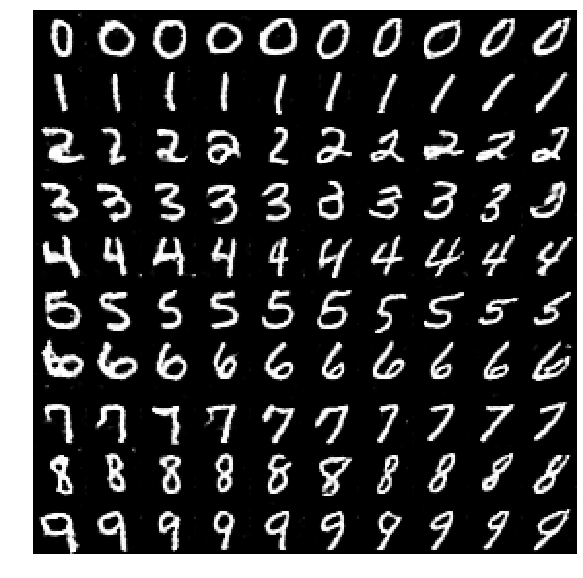

In [13]:
num_test = 10
c_min = -1.0
c_max = 1.0

# Set a list tO pring 0 ~ 9 
num_list = [4, 0, 3, 9, 7, 6, 1, 8, 2, 5]
    
img = np.zeros([img_size * num_test, img_size * num_test])

for i in range(num_test):
    for j in range(num_test):        
        c_result = np.zeros([1,n_code])
        c_result[0, num_list[i]] = 1
        
        for k in range(n_continuous):
            c_result[0,n_discrete + k] = c_min + (2*c_max/(num_test-1)) * j
        
        z_result = np.random.uniform(-1, 1, size=(1, n_latent))
        
        G_result = sess.run(G, feed_dict = {z: z_result, c: c_result, is_training: False})
                
        img[i * img_size : (i + 1) * img_size, (j) * img_size : (j + 1) * img_size] = G_result[:,:,:,0]

plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()